In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from collections import Counter
import random

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F


# Data Loading

In [98]:
train_dataset = datasets.ImageFolder(r"C:\Users\HP\OneDrive\Desktop\projectWorks\6MoodImage\moodcnnProgram\model\train")
test_dataset = datasets.ImageFolder(r"C:\Users\HP\OneDrive\Desktop\projectWorks\6MoodImage\moodcnnProgram\model\test")

# Data Preprocessing

In [99]:
print(train_dataset.classes)       
print(train_dataset.class_to_idx)  

['angry', 'happy', 'neutral', 'sad', 'surprise']
{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}


In [100]:
img, label = train_dataset[0]
img_np = np.array(img)
print(img_np.shape)

(48, 48, 3)


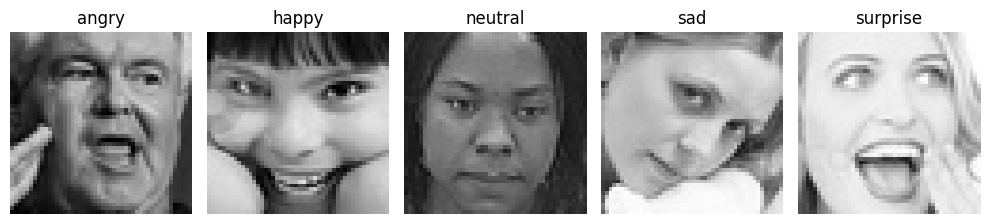

In [101]:
num_classes = len(train_dataset.classes)
fig, ax = plt.subplots(1, num_classes, figsize=(10, 3))

for cls_name, cls_idx in train_dataset.class_to_idx.items():
    # Filter only images of this class
    class_images = [path for path, label in train_dataset.samples if label == cls_idx]

    img_path = random.choice(class_images)
    img = Image.open(img_path).convert('RGB')

    ax[cls_idx].imshow(img)
    ax[cls_idx].set_title(cls_name)
    ax[cls_idx].axis('off')

plt.tight_layout()
plt.show()

In [102]:
train_counts = Counter([label for _, label in train_dataset.samples])
test_counts  = Counter([label for _, label in test_dataset.samples])
for cls, idx in train_dataset.class_to_idx.items():
    print(f"{cls}: {train_counts[idx]} images in train")

print("\n")
    
for cls, idx in train_dataset.class_to_idx.items():
    print(f"{cls}: {test_counts[idx]} images in test")

angry: 3995 images in train
happy: 7215 images in train
neutral: 4965 images in train
sad: 4830 images in train
surprise: 3171 images in train


angry: 958 images in test
happy: 1774 images in test
neutral: 1233 images in test
sad: 1247 images in test
surprise: 831 images in test


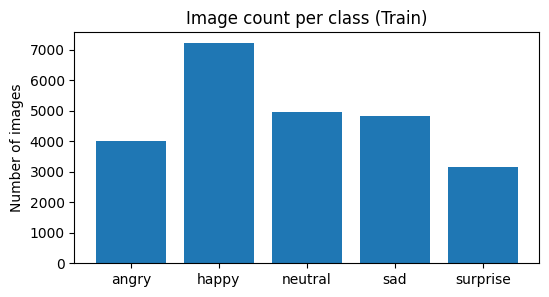

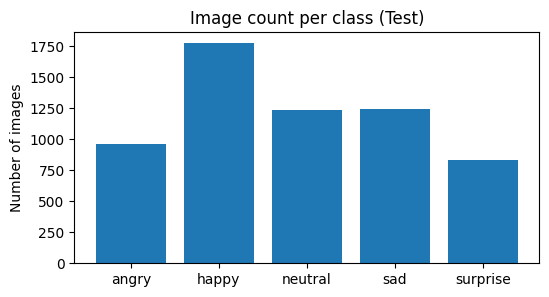

In [103]:
class_names = train_dataset.classes 

# Convert counts into ordered lists
train_values = [train_counts[i] for i in range(len(class_names))]
test_values  = [test_counts[i] for i in range(len(class_names))]

# Train dataset
plt.figure(figsize=(6,3))
plt.bar(class_names, train_values)
plt.ylabel("Number of images")
plt.title("Image count per class (Train)")
plt.show()

# Test dataset graph
plt.figure(figsize=(6,3))
plt.bar(class_names, test_values)
plt.ylabel("Number of images")
plt.title("Image count per class (Test)")
plt.show()

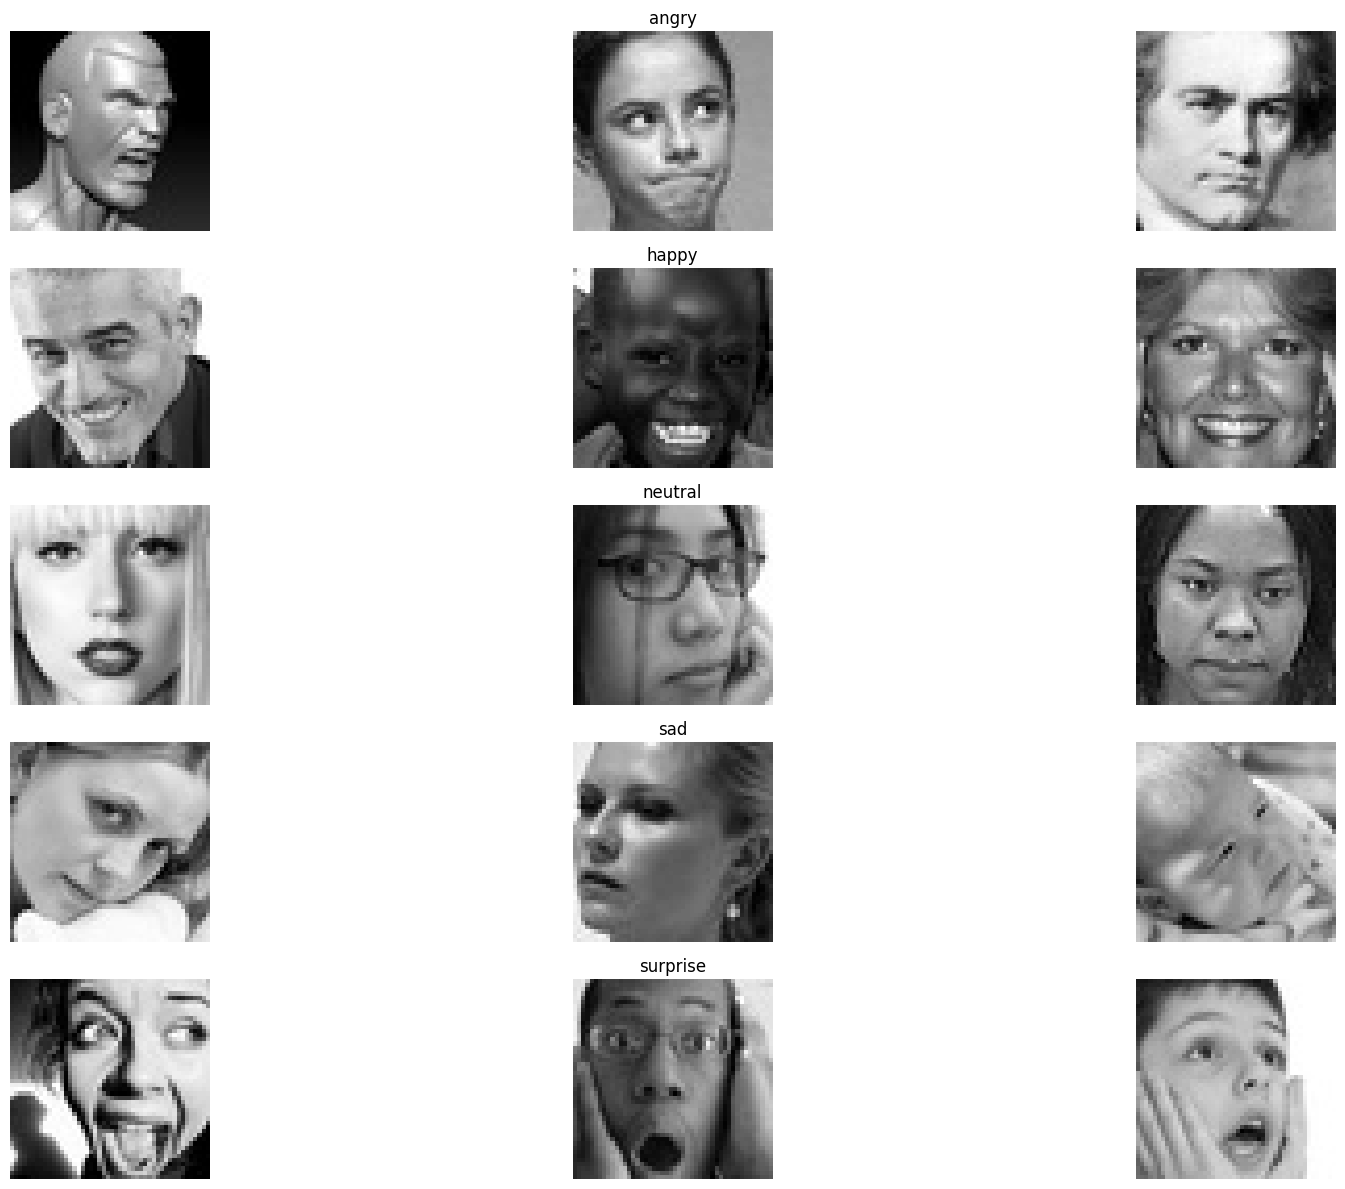

In [104]:
random.seed(42)  # fixed seed for reproducibility

num_samples = 3  # images per class
num_classes = len(train_dataset.classes)

fig, axes = plt.subplots(num_classes, num_samples, figsize=(20, 12))

for cls_name, cls_idx in train_dataset.class_to_idx.items():
    class_images = [path for path, label in train_dataset.samples if label == cls_idx]
    selected_images = random.sample(class_images, num_samples)

    for i, img_path in enumerate(selected_images):
        img = Image.open(img_path).convert("L") 
        axes[cls_idx, i].imshow(img, cmap='gray')
        axes[cls_idx, i].axis('off')
        if i == 1:  # put class name above middle image
            axes[cls_idx, i].set_title(cls_name)

plt.tight_layout()
plt.show()

- use seed and display randomly 10 photos

In [5]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations
train_transforms = transforms.Compose([
    transforms.Grayscale(),          # 1 channel
    transforms.Resize((48,48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48,48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

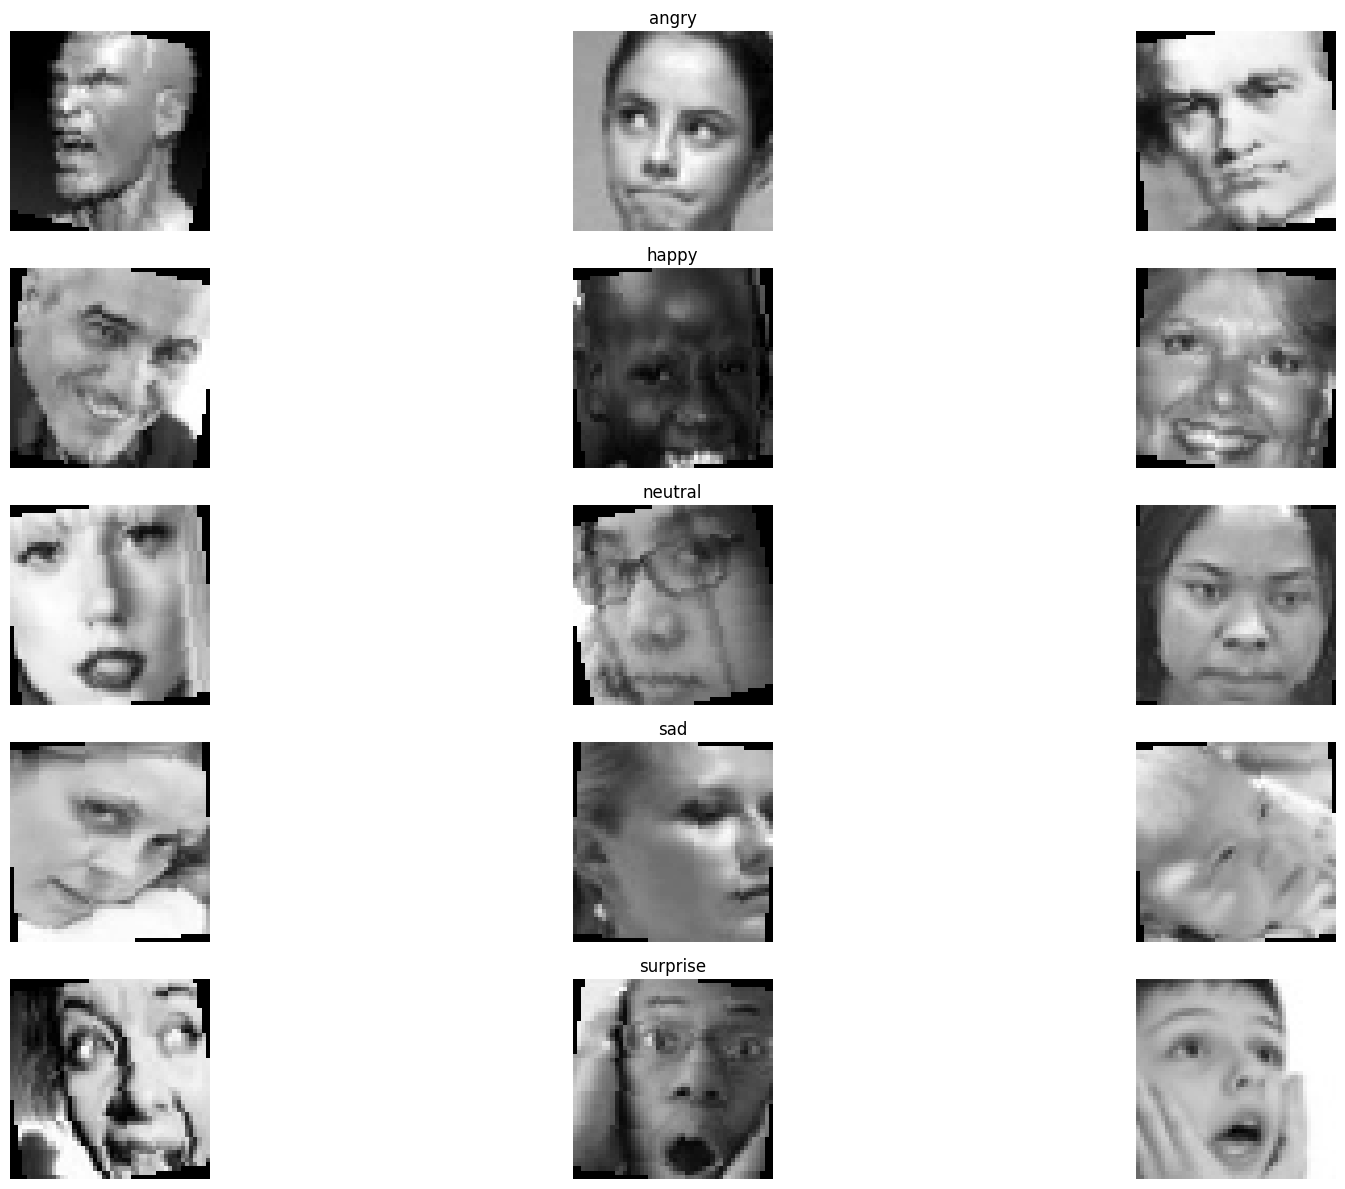

In [106]:
random.seed(42)
num_samples = 3  # images per class
num_classes = len(train_dataset.classes)

fig, axes = plt.subplots(num_classes, num_samples, figsize=(20, 12))

for cls_name, cls_idx in train_dataset.class_to_idx.items():
    class_images = [path for path, label in train_dataset.samples if label == cls_idx]
    selected_images = random.sample(class_images, num_samples)

    for i, img_path in enumerate(selected_images):
        img = Image.open(img_path).convert("L")       
        img = train_transforms(img)                   # apply augmentation
        img_show = img.squeeze().numpy()              
        axes[cls_idx, i].imshow(img_show, cmap='gray')
        axes[cls_idx, i].axis('off')
        if i == 1:
            axes[cls_idx, i].set_title(cls_name)

plt.tight_layout()
plt.show()

In [107]:
train_d = datasets.ImageFolder(r"C:\Users\HP\OneDrive\Desktop\projectWorks\6MoodImage\moodcnnProgram\model\train", transform=train_transforms)
test_d = datasets.ImageFolder(r"C:\Users\HP\OneDrive\Desktop\projectWorks\6MoodImage\moodcnnProgram\model\test", transform=test_transforms)

train_loader = DataLoader(train_d, batch_size=32, shuffle=True)
test_loader = DataLoader(test_d, batch_size=32, shuffle=False)


##### After Transform

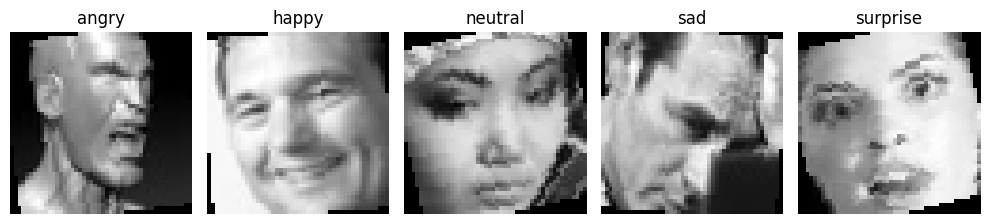

In [108]:
random.seed(42)
num_classes = len(train_loader.dataset.classes)
fig, ax = plt.subplots(1, num_classes, figsize=(10, 3))

for cls_name, cls_idx in train_loader.dataset.class_to_idx.items():
    class_indices = [i for i, (_, label) in enumerate(train_loader.dataset.samples) if label == cls_idx]

    # Pick a random index
    idx = random.choice(class_indices)
    img_tensor, label = train_loader.dataset[idx]   # **gets transformed image**

    img_show = img_tensor.squeeze().numpy()

    ax[cls_idx].imshow(img_show, cmap='gray')
    ax[cls_idx].set_title(cls_name)
    ax[cls_idx].axis('off')

plt.tight_layout()
plt.show()

# Defining Model

In [7]:
class MoodCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*3*3, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = MoodCNN(num_classes=5).to(device)

In [133]:
class_weights = torch.tensor([1.5, 1.0, 1.5, 1.5, 1.5]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Summary report of mood_cnn

In [134]:
# Number of parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable parameters: {total_params}")

# Architecture summary (from your class)
print("=== Architecture Summary ===")
print(model)

# Activation functions used (ReLU)
relu_count = sum(1 for m in model.modules() if isinstance(m, nn.ReLU))
print(f"\nActivation functions used: ReLU x {relu_count}")

# Optimizer + learning rate 
print(f"\nOptimizer: {optimizer}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")

# Training info
epochs_trained = 20
batch_size = 32
print(f"\nEpochs trained: {epochs_trained}")
print(f"Batch size: {batch_size}")

Total Trainable parameters: 245381
=== Architecture Summary ===
MoodCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1152, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=

In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=50, device=device):
    train_losses, train_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}")

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        print("Validation accuracy:", correct/total)


    # training losses
    plt.figure(figsize=(7,4))
    plt.plot(range(1, epochs+1), train_losses, 'r-o')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

    # training accuracy
    plt.figure(figsize=(7,4))
    plt.plot(range(1, epochs+1), train_accs, 'b-s')
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()


Epoch 1/50 - Loss: 0.8751 - Acc: 0.6654
Validation accuracy: 0.6663908654641735
Epoch 2/50 - Loss: 0.8630 - Acc: 0.6717
Validation accuracy: 0.6733410557670031
Epoch 3/50 - Loss: 0.8614 - Acc: 0.6753
Validation accuracy: 0.6622538474267747
Epoch 4/50 - Loss: 0.8591 - Acc: 0.6741
Validation accuracy: 0.6741684593744829
Epoch 5/50 - Loss: 0.8561 - Acc: 0.6759
Validation accuracy: 0.676650670196922
Epoch 6/50 - Loss: 0.8546 - Acc: 0.6784
Validation accuracy: 0.6783054774118815
Epoch 7/50 - Loss: 0.8410 - Acc: 0.6827
Validation accuracy: 0.6744994208174747
Epoch 8/50 - Loss: 0.8424 - Acc: 0.6792
Validation accuracy: 0.6839318219427437
Epoch 9/50 - Loss: 0.8367 - Acc: 0.6816
Validation accuracy: 0.6791328810193612
Epoch 10/50 - Loss: 0.8388 - Acc: 0.6807
Validation accuracy: 0.6723481714380275
Epoch 11/50 - Loss: 0.8324 - Acc: 0.6875
Validation accuracy: 0.6788019195763694
Epoch 12/50 - Loss: 0.8298 - Acc: 0.6858
Validation accuracy: 0.6794638424623531
Epoch 13/50 - Loss: 0.8279 - Acc: 0.68

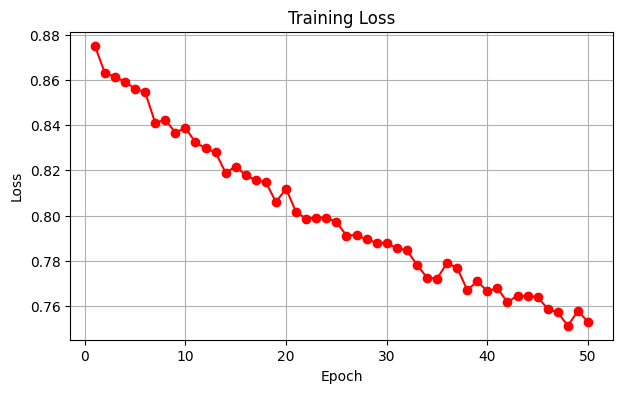

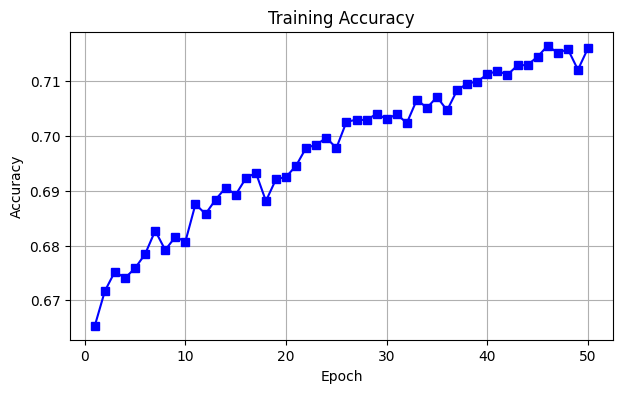

In [136]:
train_model(model, train_loader, test_loader, criterion, optimizer)

In [160]:
class_weights = torch.tensor([1.5, 1.0, 1.5, 1.5, 1.5]).to(device)
criterion1 = nn.CrossEntropyLoss(weight=class_weights)
optimizer1 = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
def train_modelSGD(model, train_loader, test_loader, criterion, optimizer, epochs=50, device=device):
    train_losses, train_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}")

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        print("Validation accuracy:", correct/total)


    # training losses
    plt.figure(figsize=(7,4))
    plt.plot(range(1, epochs+1), train_losses, 'r-o')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

    # training accuracy
    plt.figure(figsize=(7,4))
    plt.plot(range(1, epochs+1), train_accs, 'b-s')
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()


Epoch 1/20 - Loss: 0.7131 - Acc: 0.7315
Validation accuracy: 0.6970047989409234
Epoch 2/20 - Loss: 0.7127 - Acc: 0.7292
Validation accuracy: 0.6930332616250207
Epoch 3/20 - Loss: 0.7099 - Acc: 0.7329
Validation accuracy: 0.6994870097633625
Epoch 4/20 - Loss: 0.7104 - Acc: 0.7322
Validation accuracy: 0.6996524904848586
Epoch 5/20 - Loss: 0.7084 - Acc: 0.7331
Validation accuracy: 0.6989905675988747
Epoch 6/20 - Loss: 0.6991 - Acc: 0.7362
Validation accuracy: 0.6956809531689558
Epoch 7/20 - Loss: 0.7047 - Acc: 0.7354
Validation accuracy: 0.698163163991395
Epoch 8/20 - Loss: 0.6980 - Acc: 0.7347
Validation accuracy: 0.6941916266754923
Epoch 9/20 - Loss: 0.7035 - Acc: 0.7356
Validation accuracy: 0.7006453748138342
Epoch 10/20 - Loss: 0.7050 - Acc: 0.7324
Validation accuracy: 0.6976667218269071
Epoch 11/20 - Loss: 0.7054 - Acc: 0.7325
Validation accuracy: 0.6999834519278504
Epoch 12/20 - Loss: 0.6991 - Acc: 0.7333
Validation accuracy: 0.6978322025484031
Epoch 13/20 - Loss: 0.7044 - Acc: 0.73

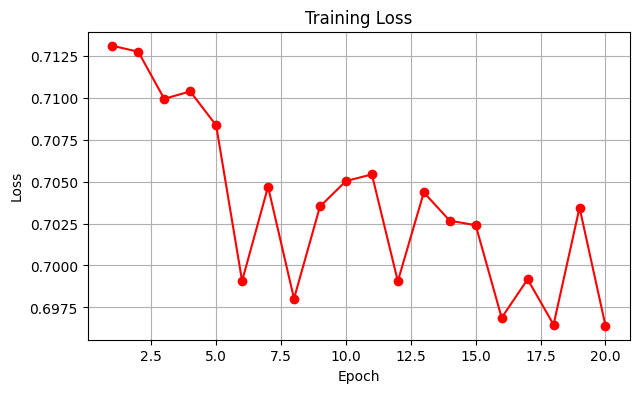

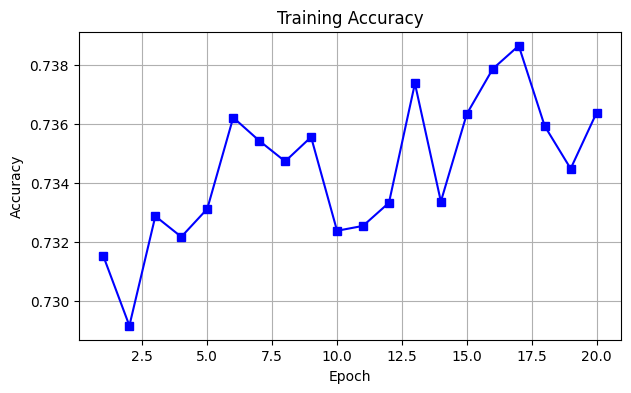

In [162]:
train_model(model, train_loader, test_loader, criterion1, optimizer1, 20)

In [3]:
svpath="C:/Users/HP/OneDrive/Desktop/projectWorks/6MoodImage/moodcnnProgram/emosion_backend/api/mood_cnn.pth"

In [138]:
print(train_loader.dataset.class_to_idx)

{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}


In [139]:
torch.save({
    'model_state_dict': model.state_dict(),
    'class_to_idx': train_loader.dataset.class_to_idx
}, svpath)


In [8]:
checkpoint = torch.load(svpath, map_location=device) ## Python dictionary containing everything saved (model_state_dict and class_to_idx).
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
class_to_idx = checkpoint['class_to_idx']
idx_to_class = {v: k for k, v in class_to_idx.items()}  # Loads the mapping of class names → label indices used during training

def predict_mood(image_path):
    img = Image.open(image_path).convert("L")
    img = test_transforms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        pred = torch.argmax(output, dim=1).item()
    return idx_to_class[pred]


# Model Evaluation

#### Final accuracies of train and test

In [141]:
def evaluate(model, data_loader, device):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = correct / total
    return acc, all_preds, all_labels

train_acc, train_preds, train_labels = evaluate(model, train_loader, device)
test_acc, test_preds, test_labels = evaluate(model, test_loader, device)

print(f"Final Train Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")


Final Train Accuracy: 0.7232
Final Test Accuracy: 0.6886


#### Confusion Matrix

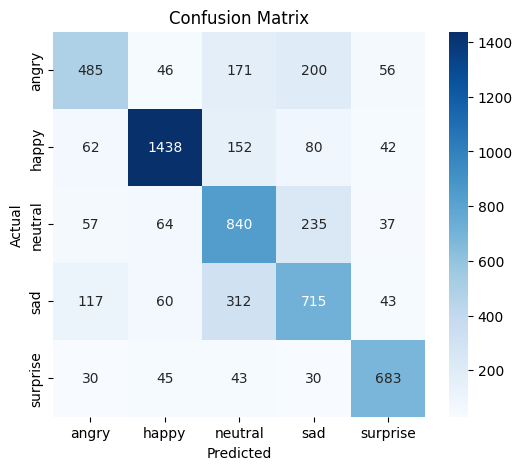

In [142]:
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=idx_to_class.values(),
            yticklabels=idx_to_class.values(), cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


#### Classification Report(Precision, Recall and F1 score)

In [143]:
print(classification_report(test_labels, test_preds, target_names=list(idx_to_class.values())))

              precision    recall  f1-score   support

       angry       0.65      0.51      0.57       958
       happy       0.87      0.81      0.84      1774
     neutral       0.55      0.68      0.61      1233
         sad       0.57      0.57      0.57      1247
    surprise       0.79      0.82      0.81       831

    accuracy                           0.69      6043
   macro avg       0.69      0.68      0.68      6043
weighted avg       0.70      0.69      0.69      6043



#### Per class Accuracy

In [144]:
per_class_acc = cm.diagonal() / cm.sum(axis=1)
per_class_error = 1 - per_class_acc

for cls, acc, err in zip(idx_to_class.values(), per_class_acc, per_class_error):
    print(f"{cls}: Accuracy={acc:.3f}, Error={err:.3f}")

angry: Accuracy=0.506, Error=0.494
happy: Accuracy=0.811, Error=0.189
neutral: Accuracy=0.681, Error=0.319
sad: Accuracy=0.573, Error=0.427
surprise: Accuracy=0.822, Error=0.178


#### Correct and incorrect prediction

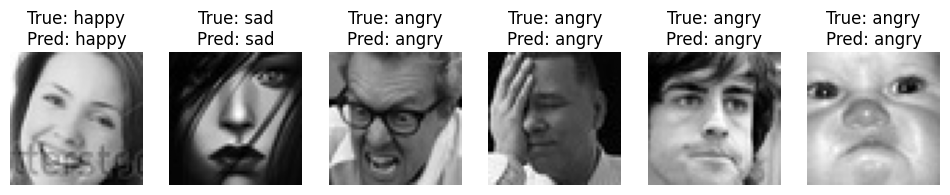

In [145]:
# pick 3 correct and 3 incorrect examples
correct_examples = [(img, lbl, pred) for (img, lbl, pred) in zip(test_dataset.samples, test_labels, test_preds) if lbl == pred]
incorrect_examples = [(img, lbl, pred) for (img, lbl, pred) in zip(test_dataset.samples, test_labels, test_preds) if lbl != pred]

examples = random.sample(correct_examples, min(3, len(correct_examples))) + \
           random.sample(incorrect_examples, min(3, len(incorrect_examples)))

plt.figure(figsize=(12,4))
for i, ((img_path, lbl), pred_lbl, _) in enumerate(examples):
    img = Image.open(img_path).convert("L")
    plt.subplot(1, len(examples), i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {idx_to_class[lbl]}\nPred: {idx_to_class[pred_lbl]}")
    plt.axis('off')
plt.show()


##### Training and Validation Graph

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

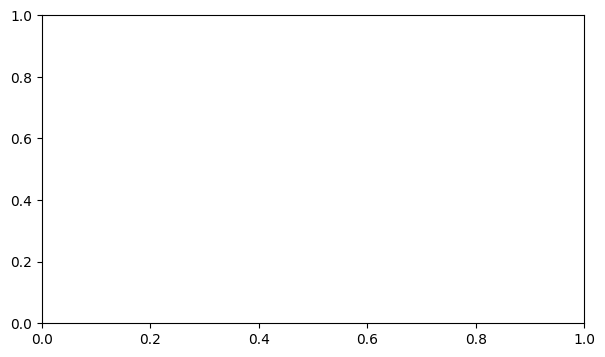

In [ ]:
# Loss
plt.figure(figsize=(7,4))
print(train_losses)
plt.plot(range(1, epochs+1), train_losses, 'r-o', label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, 'b-s', label='Test Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(7,4))
plt.plot(range(1, epochs+1), train_accs, 'r-o', label='Train Acc')
plt.plot(range(1, epochs+1), val_accs, 'b-s', label='Test Acc')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# Result for 1 image (testing)

In [16]:
mood = predict_mood("C:/Users/HP/OneDrive/Desktop/projectWorks/6MoodImage/moodcnnProgram/model/upload_photos/woman.png")
print("Predicted mood:", mood)

Predicted mood: happy
